## Pruebas

In [1]:
%pylab inline

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


In [3]:
#products = pd.read_csv('products_clean.csv')
#sales = pd.read_csv('sales_clean.csv')
#stock = pd.read_csv('stock_clean.csv')
sales_prod = pd.read_csv('sp_clean.csv')
classifier=pd.read_csv('classifier.csv')
#stock_prod = pd.read_csv('stp_clean.csv')
#groupby_sales = pd.read_csv('gb_sales_clean.csv')
#subcategories_list = pd.read_csv('subc_list_clean.csv')
#materials_list = pd.read_csv('mat_list_clean.csv')

## MODELOS ML

In [4]:
import time

import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import seaborn as sns


from datetime import datetime
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV

In [5]:
pd.set_option('display.max_columns', None)
sales_prod.head(1)

,Unnamed: 0,ID,NRO_DOCUMENTO,FECHA,CODIGO_TIENDA,TIENDA,PROD_REF,CANTIDAD,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,ANIO,MES,DIA,ITEM,REF,DESCRIPCION,CATEGORIA,SUBCATEGORIA,VIGENCIA,ORIGEN,ESTILO,MATERIAL,ACABADO,PUESTOS,COLOR,ANCHO,ALTO,FONDO,DESC_LARGA,SUBCATEGORIA_POS,COLOR_POS,MATERIAL_POS
0,0,11:FSV-00001071:XZ0862:00005:,FSV-00001071,2019-01-17,11,ADMINISTRACION,XZ0862:00005:,1,188922.0,188922,0.599999,75569,2019,1,3,6084,XZ0862:00005:,MESA AUX LAUREL,SALAS Y SOFAS,MESAS AUXILIARES,LINEA,IMPORTADO,CONTEMPORÁNEO,MADERA+VIDRIO,MATE,NaN,NEGRO,40.0,45.0,40.0,MESA AUXILIAR LAUREL 39X40X50 CRISTAL NG,OTROS,NEGRO,OTRO


In [6]:
sales_prod['AREA']=sales_prod['ANCHO']*sales_prod['FONDO']

In [7]:
sales_prod['PUESTOS'].fillna(0,inplace=True)

In [8]:

columns_HD = ['REF','TIENDA', 'PRECIO', 'SUBTOTAL','DESCUENTO(%)','TOTAL','CANTIDAD','ANIO','MES','CATEGORIA','SUBCATEGORIA','VIGENCIA','ORIGEN','ESTILO','MATERIAL','ACABADO','COLOR','ALTO','AREA','PUESTOS']
columns_LD= ['REF','TIENDA', 'PRECIO', 'SUBTOTAL','DESCUENTO(%)','TOTAL','CANTIDAD','ANIO','MES','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO','COLOR_POS','ALTO','AREA','PUESTOS']

In [9]:
sales_prod_HD=sales_prod[columns_HD]
sales_prod_LD=sales_prod[columns_LD]

<AxesSubplot:>

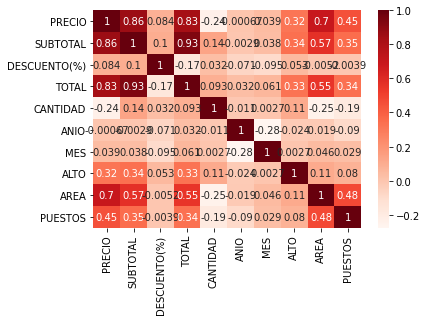

In [10]:
sns.heatmap(sales_prod_HD.corr(),cmap='Reds',annot=True)

sacar precio afuera?

**Solo por producto**

In [11]:
sales_ref_month=sales_prod_LD.groupby(['ANIO','MES','REF']).agg({'PRECIO':'mean','SUBTOTAL':'sum','DESCUENTO(%)':'mean','TOTAL':'sum','CANTIDAD':'sum','ALTO':'first','AREA':'first','PUESTOS':'first','COLOR_POS':'first','CATEGORIA':'first','SUBCATEGORIA_POS':'first','VIGENCIA':'first','ORIGEN':'first','ESTILO':'first','MATERIAL_POS':'first','ACABADO':'first'}).reset_index().sort_values(by=['ANIO','MES'])

In [12]:
covid=sales_ref_month[['ANIO','MES']].drop_duplicates().reset_index(drop=True)
aux2=[0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,3,1,1,1,2,2,1,1,2,2,1,1,1]

In [13]:
covid['Factor covid']=aux2


In [14]:
sales_ref_month=sales_ref_month.merge(covid,on=['ANIO','MES'])

<AxesSubplot:>

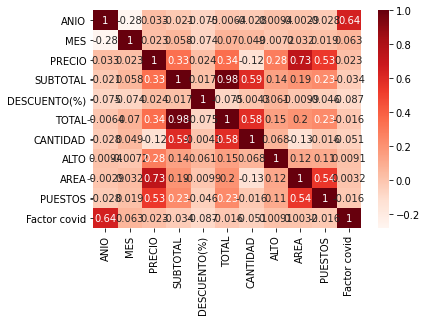

In [15]:
sns.heatmap(sales_ref_month.corr(),cmap='Reds',annot=True)

In [35]:
refs_demand=classifier[classifier.CLASSIFIER.isin(['Erratic','Intermittent'])].PROD_REF

In [59]:
sales_ref_month2=sales_ref_month[sales_ref_month.REF.isin(refs_demand)].reset_index(drop=True)

In [60]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD',]
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

In [61]:
y=sales_ref_month2['CANTIDAD']

In [62]:
X_num=sales_ref_month2[num_var[:-1]].astype('float')
X_cat=sales_ref_month2[cat_var].astype('category')

In [63]:
X_cat_dummies=pd.get_dummies(X_cat)

In [64]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [65]:
scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


In [66]:
X=np.append(X_num_norm,X_cat_dummies,axis=1)

In [120]:
#split data till januar 2021
index=sales_ref_month2[(sales_ref_month2.ANIO==2021)].index[0]
X_train=X[:index-1]
y_train=y[:index-1]
X_test=X[index:]
y_test=y[index:]


In [121]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

In [122]:
mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.348
Model:                            OLS   Adj. R-squared:                  0.294
Method:                 Least Squares   F-statistic:                     6.481
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           1.44e-39
Time:                        06:10:13   Log-Likelihood:                -3168.7
No. Observations:                 830   AIC:                             6465.
Df Residuals:                     766   BIC:                             6767.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3.885e+11   6.43e+12     -0.060      0.952    -1.3e+13    1.22e+13
x1            -2.9827      7.147     -0.417      0.677     -17.012      11.047
x2             1.2593      5.830      0.216      0.829     -10.185      12.704
x3             9.3633      3.456      2.709      0.007       2.578      16.148
x4            -5.9169      7.494     -0.790      0.430     -20.628       8.795
x5          6.157e+10   1.02e+12      0.060      0.952   -1.94e+12    2.06e+12
x6          6.157e+10   1.02e+12      0.060      0.952   -1.94e+12    2.06e+12
x7          6.157e+10   1.02e+12      0.060      0.952   -1.94e+12    2.06e+12
x8          6.157e+10   1.02e+12      0.060      0.952   -1.94e+12    2.06e+12
x9          6.157e+10   1.02e+12      0.060      0.952   -1.94e+12    2.06e+12
x10         6.157e+10   1.02e+12      0.060      0.952   -1.94e+12    2.06e+12
x11         6.157e+10   1.02e+12      0.060      0.952   -1.94e+12    2.06e+12
x12         6.157e+10   1.02e+12      0.060      0.952   -1.94e+12    2.06e+12
x13         6.157e+10   1.02e+12      0.060      0.952   -1.94e+12    2.06e+12
x14         6.157e+10   1.02e+12      0.060      0.952   -1.94e+12    2.06e+12
x15         6.157e+10   1.02e+12      0.060      0.952   -1.94e+12    2.06e+12
x16         6.157e+10   1.02e+12      0.060      0.952   -1.94e+12    2.06e+12
x17          4.28e+11   7.08e+12      0.060      0.952   -1.35e+13    1.43e+13
x18          4.28e+11   7.08e+12      0.060      0.952   -1.35e+13    1.43e+13
x19          4.28e+11   7.08e+12      0.060      0.952   -1.35e+13    1.43e+13
x20          4.28e+11   7.08e+12      0.060      0.952   -1.35e+13    1.43e+13
x21         5.884e+11   9.74e+12      0.060      0.952   -1.85e+13    1.97e+13
x22         5.884e+11   9.74e+12      0.060      0.952   -1.85e+13    1.97e+13
x23         5.884e+11   9.74e+12      0.060      0.952   -1.85e+13    1.97e+13
x24         5.884e+11   9.74e+12      0.060      0.952   -1.85e+13    1.97e+13
x25         5.884e+11   9.74e+12      0.060      0.952   -1.85e+13    1.97e+13
x26         5.884e+11   9.74e+12      0.060      0.952   -1.85e+13    1.97e+13
x27         3.568e+11    5.9e+12      0.060      0.952   -1.12e+13    1.19e+13
x28         3.568e+11    5.9e+12      0.060      0.952   -1.12e+13    1.19e+13
x29         3.568e+11    5.9e+12      0.060      0.952   -1.12e+13    1.19e+13
x30         3.568e+11    5.9e+12      0.060      0.952   -1.12e+13    1.19e+13
x31         3.568e+11    5.9e+12      0.060      0.952   -1.12e+13    1.19e+13
x32         3.568e+11    5.9e+12      0.060      0.952   -1.12e+13    1.19e+13
x33         3.568e+11    5.9e+12      0.060      0.952   -1.12e+13    1.19e+13
x34         3.568e+11    5.9e+12      0.060      0.952   -1.12e+13    1.19e+13
x35         3.568e+11    5.9e+12      0.060      0.952   -1.12e+13    1.19e+13
x3

In [135]:
y_predicted=res.predict(sm.add_constant(X_test))
mse(y_test,y_predicted)

1.6791037941401442e+21

In [136]:
from sklearn.ensemble import GradientBoostingRegressor

In [137]:
br=GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 30})

In [138]:
br.fit(X_train,y_train)

GradientBoostingRegressor(max_depth=6, n_estimators=30)

In [139]:
from sklearn.metrics import mean_squared_error as mse
mse(br.predict(X_test),y_test)

38.907615534716136

In [140]:
from sklearn.metrics import r2_score as r2
r2(br.predict(X_test),y_test)

-0.40995026829373526

In [141]:
list(zip(X_num.columns.append(X_cat_dummies.columns),br.feature_importances_))

[('AREA', 0.009186802240206062),
 ('ALTO', 0.12162371614933998),
 ('DESCUENTO(%)', 0.18920774603352628),
 ('PRECIO', 0.10335814137389202),
 ('MES_1', 0.006205037061047034),
 ('MES_2', 0.0032582581592120437),
 ('MES_3', 0.003374594662285282),
 ('MES_4', 0.00020407625211243946),
 ('MES_5', 0.0004810961300213057),
 ('MES_6', 0.03816977760389251),
 ('MES_7', 0.038099732138829154),
 ('MES_8', 0.02592101536783482),
 ('MES_9', 0.014717388142046912),
 ('MES_10', 0.0025760966830864294),
 ('MES_11', 0.00921456854471198),
 ('MES_12', 0.01730670171057905),
 ('Factor covid_0', 0.11517333494257946),
 ('Factor covid_1', 0.0019184062436797857),
 ('Factor covid_2', 0.012989991551962406),
 ('Factor covid_3', 0.00048795293920546963),
 ('PUESTOS_0.0', 0.00022230112007687008),
 ('PUESTOS_1.0', 0.007229886641607874),
 ('PUESTOS_2.0', 0.00030289957006010413),
 ('PUESTOS_3.0', 0.0011054236527423408),
 ('PUESTOS_4.0', 2.134457477064191e-05),
 ('PUESTOS_6.0', 0.0),
 ('COLOR_POS_AMARILLO', 0.0),
 ('COLOR_POS_AZU

In [142]:
param_dist = {'n_estimators':[30, 40, 100, 200, 300],'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.4, 1], 'max_depth': [2,4,6,8,10]}

In [143]:
grid_clf_br = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_squared_error')
grid_clf_br.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_squared_error')

In [144]:
grid_clf_br.best_score_

-171.6629172971021

In [145]:
grid_clf_br.best_params_

{'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}

In [146]:
best={'learning_rate': 0.05, 'max_depth': 2, 'n_estimators': 100}

In [147]:
mse(grid_clf_br.predict(X_test),y_test)

32.227916051336884

In [148]:
y_predicted2=grid_clf_br.predict(X_test)

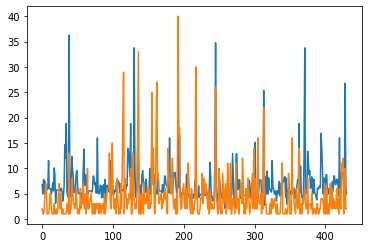

In [149]:
plt.figure()
plt.plot(range(len(y_predicted2)),(y_predicted2))
plt.plot(range(len(y_predicted2)),(y_test))

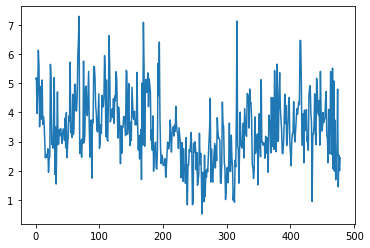

In [46]:
plt.plot(range(len(y_predicted2)),(y_predicted2))

In [ ]:
import sklearn

In [ ]:
sklearn.metrics.SCORERS.keys()

Lasso o Ridge?

In [150]:
from sklearn.linear_model import Ridge, Lasso

In [151]:
rr=Ridge(alpha=1000)
rr.fit(X_train,y_train)
mse(y_test,rr.predict(X_test))


31.82365708127513

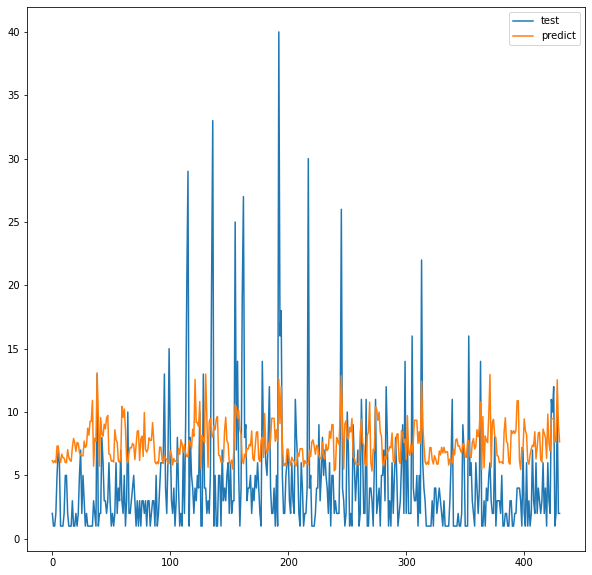

In [152]:
plt.figure(figsize=(10,10))
plt.plot(range(len(rr.predict(X_test))),y_test,label='test')
plt.plot(range(len(rr.predict(X_test))),rr.predict(X_test),label='predict')
plt.legend()

In [153]:
rr=Lasso(alpha=0.0555)
rr.fit(X_train,y_train)
mse(y_test,rr.predict(X_test))


47.840775042506

again but scaling numerical features

In [154]:
from scipy import stats

In [155]:
X_num['DESCUENTO(%)']=X_num['DESCUENTO(%)']+0.00001
num_columns=['AREA','ALTO','DESCUENTO(%)','PRECIO'] #Descuento no se puede porque tiene 0
X_num_tran=pd.DataFrame(index=sales_ref_month2.index)
lambdas=[]
for column in num_columns:
    aux=stats.boxcox(X_num[column])
    X_num_tran["{}_TRANSFORMADO".format(column)]=aux[0]
    lambdas.append(aux[1])
    print (column,aux[1])
y_trans=stats.boxcox(y)[0]
print(y.name,stats.boxcox(y)[1])
lambda_y=stats.boxcox(y)[1]

AREA 0.10220207009721177
ALTO 0.6025773460223602
DESCUENTO(%) 1.0749882886283075
PRECIO -0.07000974441174783
CANTIDAD -0.19165518162492665


In [156]:
X_num_norm2= scaler.fit_transform(X_num_tran)
y_norm2=scaler.fit_transform(y.values.reshape(-1,1))

#X=np.append(X_num_norm2,X_cat_dummies,axis=1)
X=pd.concat([X_num_tran,X_cat_dummies],axis=1)
#split data till januar 2021
index=sales_ref_month2[(sales_ref_month2.ANIO==2021)].index[0]
X_train=X[:index]
y_train=y_trans[:index]
X_test=X[index:]
y_test=y_trans[index:]

import statsmodels.api as sm

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.314
Model:                            OLS   Adj. R-squared:                  0.258
Method:                 Least Squares   F-statistic:                     5.581
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           1.18e-32
Time:                        06:15:18   Log-Likelihood:                -807.57
No. Observations:                 831   AIC:                             1743.
Df Residuals:                     767   BIC:                             2045.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
=======================================================================================================
                                          coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------
const                                   1.2492      0.618      2.022      0.044       0.036       2.462
AREA_TRANSFORMADO                      -0.0453      0.045     -1.018      0.309      -0.133       0.042
ALTO_TRANSFORMADO                      -0.0024      0.014     -0.163      0.870      -0.031       0.026
DESCUENTO(%)_TRANSFORMADO               0.8566      0.274      3.126      0.002       0.319       1.394
PRECIO_TRANSFORMADO                    -0.2197      0.269     -0.815      0.415      -0.749       0.309
MES_1                                   0.1461      0.119      1.232      0.218      -0.087       0.379
MES_2                                  -0.0136      0.121     -0.112      0.911      -0.252       0.225
MES_3                                  -0.1378      0.150     -0.916      0.360      -0.433       0.157
MES_4                                  -0.2419      0.164     -1.473      0.141      -0.564       0.080
MES_5                                  -0.0073      0.140     -0.052      0.958      -0.281       0.267
MES_6                                   0.3563      0.107      3.324      0.001       0.146       0.567
MES_7                                   0.3277      0.103      3.192      0.001       0.126       0.529
MES_8                                  -0.1183      0.113     -1.044      0.297      -0.341       0.104
MES_9                                   0.0745      0.106      0.700      0.484      -0.134       0.283
MES_10                                  0.3190      0.097      3.287      0.001       0.128       0.509
MES_11                                  0.3427      0.095      3.590      0.000       0.155       0.530
MES_12                                  0.2020      0.109      1.852      0.064      -0.012       0.416
Factor covid_0                          0.4263      0.155      2.755      0.006       0.123       0.730
Factor covid_1                          0.2315      0.174      1.330      0.184      -0.110       0.573
Factor covid_2                          0.4013      0.179      2.239      0.025       0.049       0.753
Factor covid_3                          0.1902      0.217      0.878      0.380      -0.235       0.615
PUESTOS_0.0                             0.3158      0.179      1.760      0.079      -0.036       0.668
PUESTOS_1.0                             0.8718      0.197      4.414      0.000       0.484       1.259
PUESTOS_2.0                            -0.3249      0.204     -1.591      0.112      -0.726       0.076
PUESTOS_3.0                            -0.6169      0.277     -2.226      0.026      -1.161      -0.073
PUESTOS_4.0                             0.3302      0.220      1.504      0.133      -0.101       0.761
PUESTOS_6.0                             0.6733      0.246      2.74

In [157]:
res2=res.predict(sm.add_constant(X_test,has_constant='add'))

In [158]:
def inversebox(y,lmbda):
    return (y*lmbda +1)**(1/lmbda)
y_true_test=inversebox(y_test,lambda_y)
y_true_res=inversebox(res2,lambda_y)

In [162]:
mse(y_true_test,y_true_res)

26.00739494040489

malos modelos....

probemos laggy sales variables ojo pues son ventas anteriores no ordenadas

In [169]:
def sales_ref_month2_lag_generator(n):
    sales_ref_month2_lag=sales_ref_month2.copy()
    for i in range(n):
        sales_ref_month2_lag['CANTIDAD_{}'.format(i+1)]=sales_ref_month2.groupby(['REF'])[['CANTIDAD']].shift(i+1)
    return sales_ref_month2_lag

In [170]:
sales_ref_month2_lag=sales_ref_month2_lag_generator(12).dropna().reset_index(drop=True)

In [173]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO']
for i in range(1,13):
    num_var.append('CANTIDAD_{}'.format(i))
num_var.append('CANTIDAD')
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_ref_month2_lag['CANTIDAD']

X_num=sales_ref_month2_lag[num_var[:-1]].astype('float')
X_cat=sales_ref_month2_lag[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till month 4 from 2021
index=sales_ref_month2_lag[(sales_ref_month2_lag.ANIO==2021) & (sales_ref_month2_lag.MES==4)].head(1).index.values[0]
X_train=X[:index-1]
y_train=(y[:index-1])
X_test=X[index:]
y_test=(y[index:])


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.854
Model:                            OLS   Adj. R-squared:                  0.780
Method:                 Least Squares   F-statistic:                     11.66
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           4.20e-27
Time:                        06:19:48   Log-Likelihood:                -508.67
No. Observations:                 166   AIC:                             1129.
Df Residuals:                     110   BIC:                             1304.
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2489      1.530      1.470      0.144      -0.782       5.280
x1            -0.5043      2.690     -0.187      0.852      -5.835       4.826
x2             1.8600      3.484      0.534      0.595      -5.045       8.765
x3            -1.9550      4.173     -0.468      0.640     -10.225       6.315
x4           -27.1684     19.639     -1.383      0.169     -66.089      11.752
x5            26.7888      8.168      3.280      0.001      10.601      42.976
x6           -25.7287      7.180     -3.584      0.001     -39.957     -11.501
x7            12.8656      7.237      1.778      0.078      -1.477      27.208
x8           -13.5491      7.122     -1.903      0.060     -27.662       0.564
x9            -8.7526      7.291     -1.200      0.233     -23.202       5.697
x10           22.3310      7.313      3.054      0.003       7.839      36.824
x11           -2.6227      7.276     -0.360      0.719     -17.042      11.796
x12           15.3044      6.859      2.231      0.028       1.712      28.897
x13          -19.6530      6.860     -2.865      0.005     -33.248      -6.058
x14           11.0428      6.171      1.790      0.076      -1.186      23.272
x15            1.2095      6.209      0.195      0.846     -11.095      13.514
x16           -0.6806      5.554     -0.123      0.903     -11.688      10.327
x17            5.7120      4.453      1.283      0.202      -3.113      14.537
x18           -4.6404      2.477     -1.873      0.064      -9.550       0.269
x19           -6.2902      2.759     -2.280      0.025     -11.759      -0.822
x20           -5.5958      8.799     -0.636      0.526     -23.034      11.842
x21           -3.9933      6.649     -0.601      0.549     -17.171       9.184
x22            0.0247      3.445      0.007      0.994      -6.803       6.853
x23           -5.5508      3.105     -1.788      0.077     -11.705       0.603
x24            6.8975      5.314      1.298      0.197      -3.634      17.429
x25           13.9188      5.017      2.774      0.007       3.975      23.862
x26           -3.4398      2.986     -1.152      0.252      -9.357       2.477
x27           -2.8918      2.787     -1.038      0.302      -8.415       2.632
x28            8.0981      4.732      1.711      0.090      -1.279      17.475
x29            2.2812      2.891      0.789      0.432      -3.448       8.011
x30            5.2828      2.610      2.024      0.045       0.110      10.456
x31           -8.5730      4.752     -1.804      0.074     -17.990       0.844
x32            3.2580      4.088      0.797      0.427      -4.844      11.360
x33           -3.0104      4.347     -0.693      0.490     -11.625       5.604
x34            1.2583      2.388      0.527      0.599      -3.475       5.992
x35           -0.0685      2.143     -0.032      0.975      -4.316       4.179
x3

In [174]:
y_predicted=res.predict(sm.add_constant(X_test, has_constant='add'))
mse(y_test,y_predicted)

81.84989800830876

In [176]:
y_test

167     1
168     2
169     3
170     1
171     6
172     4
173     2
174     4
175    14
176     1
177     3
178     1
179     4
180     3
181     5
182     6
183     1
184     1
185     2
186    10
187     2
188     2
Name: CANTIDAD, dtype: int64

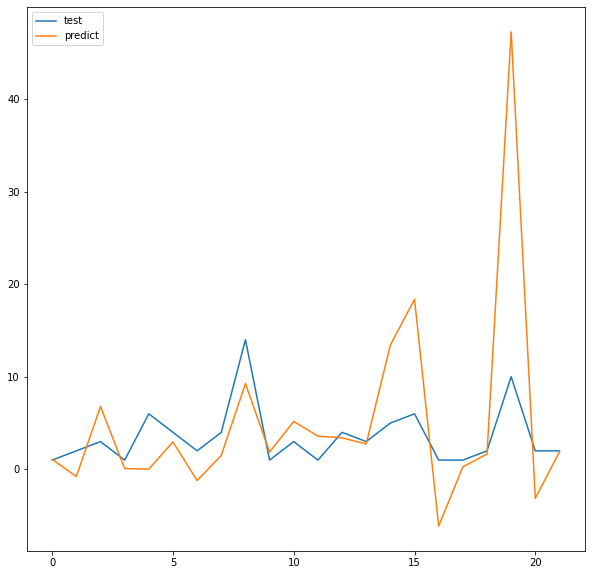

In [178]:
plt.figure(figsize=(10,10))
plt.plot(range(len(res.predict(sm.add_constant(X_test, has_constant='add')))),y_test,label='test')
plt.plot(range(len(res.predict(sm.add_constant(X_test, has_constant='add')))),res.predict(sm.add_constant(X_test, has_constant='add')),label='predict')
plt.legend()

In [179]:
br=GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 40})

br.fit(X_train,y_train)


GradientBoostingRegressor(max_depth=7, n_estimators=40)

In [180]:
mse(y_test,br.predict(X_test))

11.037546592797614

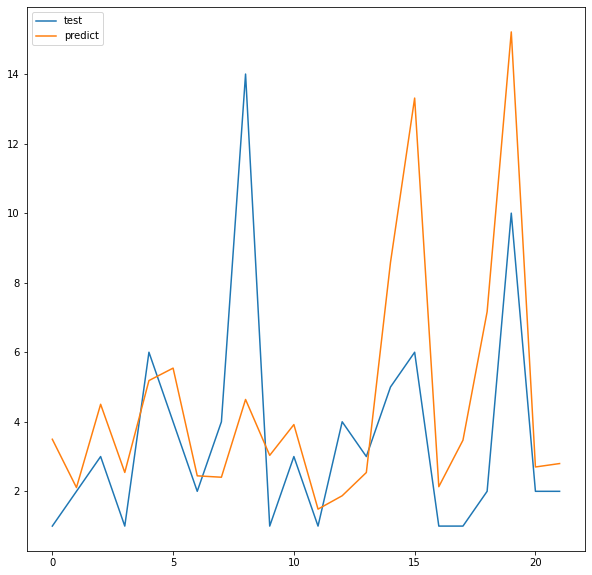

In [181]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),br.predict(X_test),label='predict')
plt.legend()

In [182]:
param_dist = {'n_estimators':[30, 40, 100, 200, 300],'learning_rate':[0.01, 0.05, 0.1, 0.3, 0.4, 1], 'max_depth': [2,4,6,8,10]}

grid_br_mae = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_absolute_error')
grid_br_mae.fit(X_train, y_train)



GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_absolute_error')

In [183]:
grid_br_mae.best_score_

-5.632323604351534

In [184]:
grid_br_mae.best_params_

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 30}

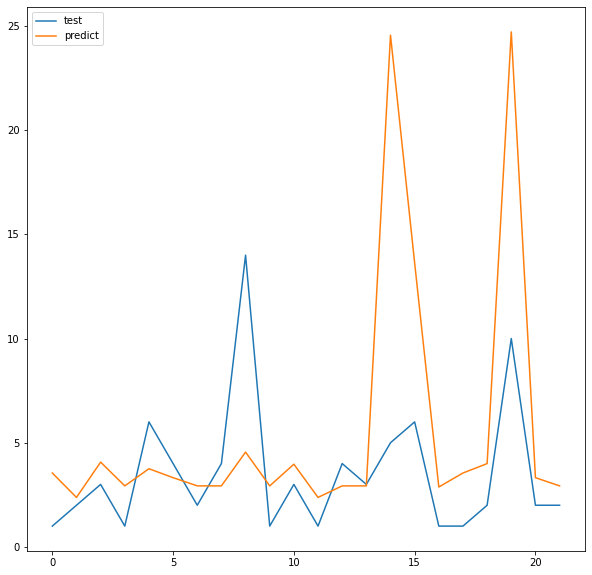

In [185]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mae.predict(X_test),label='predict')
plt.legend()

In [186]:
grid_br_mape = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_absolute_percentage_error')
grid_br_mape.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error')

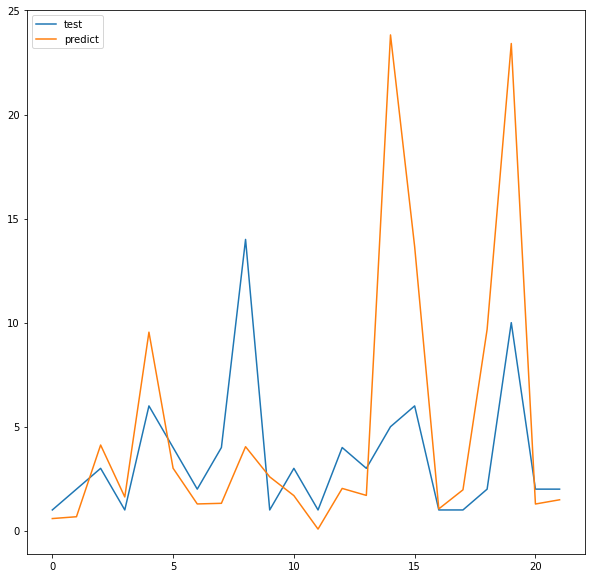

In [187]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mape.predict(X_test),label='predict')
plt.legend()

In [188]:
from sklearn.metrics import mean_absolute_percentage_error as mape
mape(grid_br_mape.predict(X_test),y_test)

1.263672348237535

Una forma mas general por caracteristicas

In [189]:
sales_cat=sales_ref_month2.groupby(['ANIO','MES','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','MATERIAL_POS','ESTILO','ACABADO','PUESTOS','VIGENCIA','ORIGEN']).agg({'PRECIO':'mean','SUBTOTAL':'sum','DESCUENTO(%)':'mean','TOTAL':'sum','CANTIDAD':'sum','ALTO':'mean','AREA':'mean','Factor covid':'first'}).reset_index()

In [190]:

sales_cat

,ANIO,MES,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,MATERIAL_POS,ESTILO,ACABADO,PUESTOS,VIGENCIA,ORIGEN,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,CANTIDAD,ALTO,AREA,Factor covid
0,2019,1,AZUL,COMEDORES,SILLAS DE COMEDOR,SINTÉTICO,MODERNO,SUPERFICIES MATES,1.0,LINEA,IMPORTADO,1.640620e+05,2296868,0.293750,1583198,14,99.0,2352.0,0
1,2019,1,BLANCO,COMEDORES,SILLAS DE COMEDOR,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,LINEA,IMPORTADO,2.462975e+05,985190,0.749999,246298,4,77.0,1880.0,0
2,2019,1,CAFE,SALAS Y SOFAS,RECLINABLES,MICROFIBRA,C+M - CLÁSICO + MODERNO,TEXTILES SUAVES,3.0,LINEA,IMPORTADO,2.068509e+06,18616580,0.350000,12100775,9,108.0,18270.0,0
3,2019,1,CAFE,SALAS Y SOFAS,RECLINABLES,MICROFIBRA,MODERNO,TEXTILES SUAVES,2.0,LINEA,IMPORTADO,1.868976e+06,24296692,0.338462,15792843,13,108.0,13920.0,0
4,2019,1,NEGRO,COMEDORES,SILLAS DE COMEDOR,SINTÉTICO,MODERNO,SUPERFICIES MATES,1.0,LINEA,IMPORTADO,1.544989e+05,3188529,0.300001,2967611,17,100.0,2189.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1103,2021,4,OTRO,SALAS Y SOFAS,OTROS,OTRO,CONTEMPORÁNEO,MATE,0.0,NOVEDAD,IMPORTADO,3.009058e+05,1234345,0.396578,742356,4,43.5,3050.0,1
1104,2021,4,OTRO,SALAS Y SOFAS,POLTRONAS,MICROFIBRA,CONTEMPORÁNEO,MADERA NATURAL,1.0,LINEA,MANUFACTURADO,6.607320e+05,1982196,0.390642,1207866,3,79.0,5184.0,1
1105,2021,4,OTRO,SALAS Y SOFAS,SILLAS AUXILIARES,MICROFIBRA,CONTEMPORÁNEO,TEXTILES SUAVES,1.0,NOVEDAD,IMPORTADO,3.886010e+05,1554404,0.412902,913511,4,73.0,3672.0,1
1106,2021,4,OTRO,SALAS Y SOFAS,SOFA CAMA ABATIBLE,MICROFIBRA,MODERNO,TEXTILES SUAVES,3.0,LINEA,MANUFACTURADO,6.610620e+05,661062,0.543489,301782,1,82.0,16744.0,1


In [191]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO','CANTIDAD',]
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_cat['CANTIDAD']

X_num=sales_cat[num_var[:-1]].astype('float')
X_cat=sales_cat[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till januar 2021
index=sales_cat[(sales_cat.ANIO==2021)].index[0]
X_train=X[:index-1]
y_train=y[:index-1]
X_test=X[index:]
y_test=y[index:]


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.349
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     5.954
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           8.11e-35
Time:                        06:24:34   Log-Likelihood:                -2970.0
No. Observations:                 764   AIC:                             6068.
Df Residuals:                     700   BIC:                             6365.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.278e+13   3.44e+13     -0.372      0.710   -8.03e+13    5.47e+13
x1             1.6992     11.232      0.151      0.880     -20.354      23.752
x2            22.4814      9.667      2.326      0.020       3.502      41.461
x3            10.1230      3.834      2.641      0.008       2.596      17.650
x4            -9.1316      8.773     -1.041      0.298     -26.355       8.092
x5         -9.364e+11   2.52e+12     -0.372      0.710   -5.88e+12    4.01e+12
x6         -9.364e+11   2.52e+12     -0.372      0.710   -5.88e+12    4.01e+12
x7         -9.364e+11   2.52e+12     -0.372      0.710   -5.88e+12    4.01e+12
x8         -9.364e+11   2.52e+12     -0.372      0.710   -5.88e+12    4.01e+12
x9         -9.364e+11   2.52e+12     -0.372      0.710   -5.88e+12    4.01e+12
x10        -9.364e+11   2.52e+12     -0.372      0.710   -5.88e+12    4.01e+12
x11        -9.364e+11   2.52e+12     -0.372      0.710   -5.88e+12    4.01e+12
x12        -9.364e+11   2.52e+12     -0.372      0.710   -5.88e+12    4.01e+12
x13        -9.364e+11   2.52e+12     -0.372      0.710   -5.88e+12    4.01e+12
x14        -9.364e+11   2.52e+12     -0.372      0.710   -5.88e+12    4.01e+12
x15        -9.364e+11   2.52e+12     -0.372      0.710   -5.88e+12    4.01e+12
x16        -9.364e+11   2.52e+12     -0.372      0.710   -5.88e+12    4.01e+12
x17        -2.747e+11   7.39e+11     -0.372      0.710   -1.73e+12    1.18e+12
x18        -2.747e+11   7.39e+11     -0.372      0.710   -1.73e+12    1.18e+12
x19        -2.747e+11   7.39e+11     -0.372      0.710   -1.73e+12    1.18e+12
x20        -2.747e+11   7.39e+11     -0.372      0.710   -1.73e+12    1.18e+12
x21        -2.864e+12    7.7e+12     -0.372      0.710    -1.8e+13    1.23e+13
x22        -2.864e+12    7.7e+12     -0.372      0.710    -1.8e+13    1.23e+13
x23        -2.864e+12    7.7e+12     -0.372      0.710    -1.8e+13    1.23e+13
x24        -2.864e+12    7.7e+12     -0.372      0.710    -1.8e+13    1.23e+13
x25        -2.864e+12    7.7e+12     -0.372      0.710    -1.8e+13    1.23e+13
x26        -2.864e+12    7.7e+12     -0.372      0.710    -1.8e+13    1.23e+13
x27        -1.462e+12   3.93e+12     -0.372      0.710   -9.19e+12    6.26e+12
x28        -1.462e+12   3.93e+12     -0.372      0.710   -9.19e+12    6.26e+12
x29        -1.462e+12   3.93e+12     -0.372      0.710   -9.19e+12    6.26e+12
x30        -1.462e+12   3.93e+12     -0.372      0.710   -9.19e+12    6.26e+12
x31        -1.462e+12   3.93e+12     -0.372      0.710   -9.19e+12    6.26e+12
x32        -1.462e+12   3.93e+12     -0.372      0.710   -9.19e+12    6.26e+12
x33        -1.462e+12   3.93e+12     -0.372      0.710   -9.19e+12    6.26e+12
x34        -1.462e+12   3.93e+12     -0.372      0.710   -9.19e+12    6.26e+12
x35        -1.462e+12   3.93e+12     -0.372      0.710   -9.19e+12    6.26e+12
x3

In [192]:
X_test

y_predicted=res.predict(sm.add_constant(X_test))
mse(y_test,y_predicted)


4.190409221397695e+22

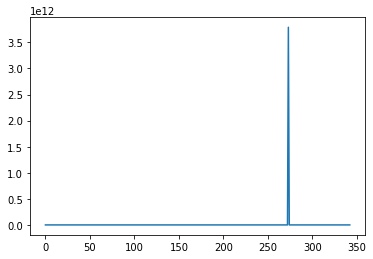

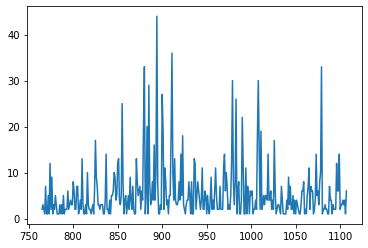

In [193]:
plt.figure()
plt.plot(y_predicted)
plt.figure()
plt.plot(y_test)

In [194]:
br=GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 4, 'n_estimators': 40})

br.fit(X_train,y_train)

br.predict(X_test)


array([ 3.10949966,  5.38297517,  8.63974116,  8.39598576,  7.14492484,
       10.65331452,  5.23131616,  5.38297517,  8.09982252,  7.21606656,
        7.00996021, 10.12603081,  6.81317784, 10.26682041,  5.34858499,
        8.63974116,  7.87528152,  4.40588449,  3.83714336,  8.4783986 ,
        6.29245565, 11.51515138,  5.39374205,  5.90983654,  7.32633036,
        7.32633036,  5.88752583,  4.7339253 ,  4.18642417,  7.00996021,
        4.52823685, 36.27213162,  7.58670335,  7.29332074,  7.53934888,
        8.08989544,  7.34864542,  6.45974511,  5.20007081,  5.92708237,
        4.69767424,  5.92708237,  5.58526969,  5.58526969, 15.7648941 ,
       29.457851  ,  3.80785262, 12.0589024 ,  6.24544387,  2.85946892,
        3.70308707,  5.43260468,  3.38589241,  5.33361226,  6.27006189,
        4.75575856,  4.03834871,  4.13273963,  6.47057756,  8.58409105,
       12.77900578, 21.17994315,  5.20367349,  3.86412231,  6.0986059 ,
        5.0258369 ,  7.5544252 ,  9.74731586,  7.7173503 ,  5.23

In [195]:
mse(y_test,br.predict(X_test))

47.881918073608894

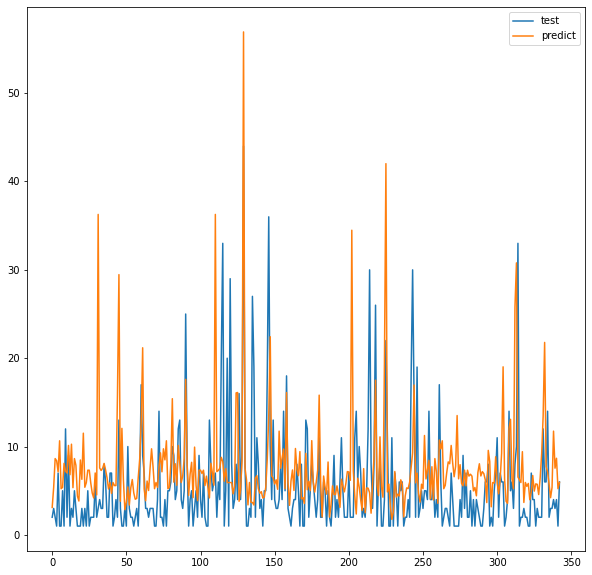

In [196]:
plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),br.predict(X_test),label='predict')
plt.legend()

ahora con lag

In [197]:
sales_cat_lag=sales_cat.copy()


In [198]:
for i in range(12):
    sales_cat_lag['CANTIDAD_{}'.format(i+1)]=sales_cat.groupby(['COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','MATERIAL_POS','ESTILO','ACABADO'])[['CANTIDAD']].shift(i+1)

In [199]:
sales_cat_lag=sales_cat_lag.dropna()
sales_cat_lag=sales_cat_lag.reset_index(drop=True)


<AxesSubplot:>

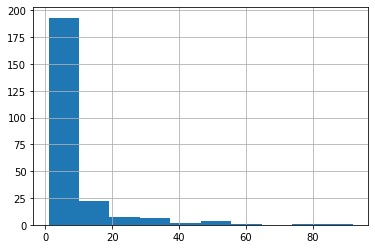

In [200]:
sales_cat_lag['CANTIDAD'].hist()

In [201]:
sales_cat_lag[sales_cat_lag['CANTIDAD']>45]['SUBCATEGORIA_POS'].value_counts()

SILLAS DE COMEDOR    7
Name: SUBCATEGORIA_POS, dtype: int64

In [202]:
sales_cat_lag.head(5)

,ANIO,MES,COLOR_POS,CATEGORIA,SUBCATEGORIA_POS,MATERIAL_POS,ESTILO,ACABADO,PUESTOS,VIGENCIA,ORIGEN,PRECIO,SUBTOTAL,DESCUENTO(%),TOTAL,CANTIDAD,ALTO,AREA,Factor covid,CANTIDAD_1,CANTIDAD_2,CANTIDAD_3,CANTIDAD_4,CANTIDAD_5,CANTIDAD_6,CANTIDAD_7,CANTIDAD_8,CANTIDAD_9,CANTIDAD_10,CANTIDAD_11,CANTIDAD_12
0,2019,8,OTRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,6.0,LINEA,IMPORTADO,906879.0,3627516,0.4625,1949790,4,75.0,13500.0,0,2.0,10.0,7.0,7.0,4.0,11.0,5.0,3.0,2.0,13.0,2.0,3.0
1,2019,9,OTRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,6.0,LINEA,IMPORTADO,906880.0,7255040,0.3500,4715776,8,75.0,13500.0,0,4.0,2.0,10.0,7.0,7.0,4.0,11.0,5.0,3.0,2.0,13.0,2.0
2,2019,10,OTRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,0.0,LINEA,IMPORTADO,200000.0,800000,0.6000,320000,4,75.0,2700.0,0,8.0,4.0,2.0,10.0,7.0,7.0,4.0,11.0,5.0,3.0,2.0,13.0
3,2019,10,OTRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,6.0,LINEA,IMPORTADO,906880.0,1813760,0.3750,1133600,2,75.0,13500.0,0,4.0,8.0,4.0,2.0,10.0,7.0,7.0,4.0,11.0,5.0,3.0,2.0
4,2019,11,OTRO,COMEDORES,OTROS,VIDRIO,MODERNO,BRILLANTE,0.0,LINEA,IMPORTADO,200000.0,1000000,0.6000,400000,5,75.0,2700.0,0,2.0,4.0,8.0,4.0,2.0,10.0,7.0,7.0,4.0,11.0,5.0,3.0


<AxesSubplot:>

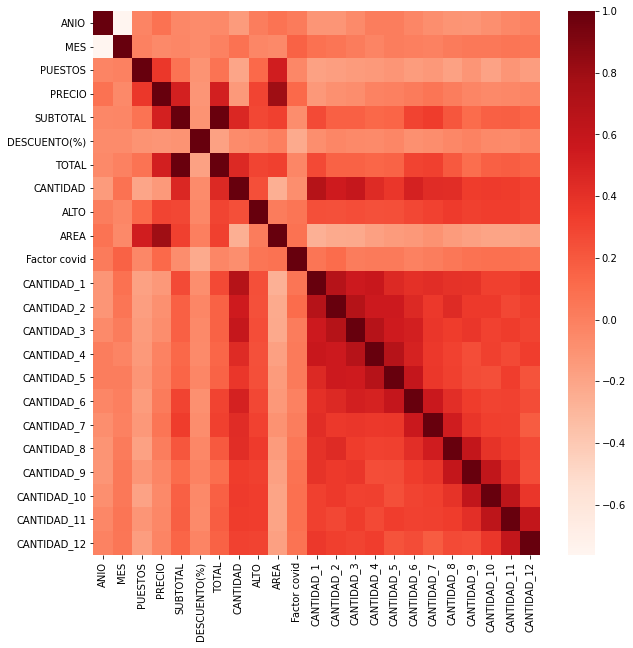

In [203]:
plt.figure(figsize=(10,10))
sns.heatmap(sales_cat_lag.corr(),cmap='Reds')

In [204]:
num_var=['AREA','ALTO','DESCUENTO(%)','PRECIO']
for i in range(1,13):
    num_var.append('CANTIDAD_{}'.format(i))
num_var.append('CANTIDAD')
cat_var=['MES','Factor covid','PUESTOS','COLOR_POS','CATEGORIA','SUBCATEGORIA_POS','VIGENCIA','ORIGEN','ESTILO','MATERIAL_POS','ACABADO']

y=sales_cat_lag['CANTIDAD']

X_num=sales_cat_lag[num_var[:-1]].astype('float')
X_cat=sales_cat_lag[cat_var].astype('category')

X_cat_dummies=pd.get_dummies(X_cat)

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
X_num_norm= scaler.fit_transform(X_num)


X=np.append(X_num_norm,X_cat_dummies,axis=1)

#split data till month 4 from 2021
index=sales_cat_lag[(sales_cat_lag.ANIO==2021) & (sales_cat_lag.MES==4)].head(1).index.values[0]
X_train=X[:index-1]
y_train=(y[:index-1])
X_test=X[index:]
y_test=(y[index:])


import statsmodels.api as sm
from sklearn.metrics import mean_squared_error as mse

mod = sm.OLS(y_train, sm.add_constant(X_train))
res = mod.fit()
res.summary()




<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               CANTIDAD   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     9.340
Date:                Sat, 28 Aug 2021   Prob (F-statistic):           2.09e-28
Time:                        06:25:28   Log-Likelihood:                -659.16
No. Observations:                 208   AIC:                             1446.
Df Residuals:                     144   BIC:                             1660.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         96.0088     53.139      1.807      0.073      -9.024     201.042
x1          -274.5192    227.010     -1.209      0.229    -723.221     174.183
x2          -225.0453     70.001     -3.215      0.002    -363.408     -86.683
x3             1.3345      4.184      0.319      0.750      -6.935       9.604
x4            -0.5503     18.134     -0.030      0.976     -36.394      35.294
x5            32.7661      6.651      4.927      0.000      19.620      45.912
x6           -24.5425      6.746     -3.638      0.000     -37.876     -11.208
x7            14.5963      7.003      2.084      0.039       0.755      28.438
x8           -16.9407      6.808     -2.488      0.014     -30.398      -3.484
x9           -14.4717      6.702     -2.159      0.032     -27.718      -1.226
x10           17.9857      6.440      2.793      0.006       5.256      30.716
x11           -4.3754      5.884     -0.744      0.458     -16.005       7.254
x12           16.9166      5.684      2.976      0.003       5.682      28.151
x13          -15.2678      6.135     -2.489      0.014     -27.393      -3.142
x14            3.3496      5.856      0.572      0.568      -8.225      14.924
x15            4.2450      5.891      0.721      0.472      -7.399      15.889
x16           -1.7950      5.354     -0.335      0.738     -12.377       8.787
x17            7.6655      5.139      1.492      0.138      -2.492      17.823
x18            6.9167      4.713      1.468      0.144      -2.399      16.232
x19            4.0555      4.820      0.841      0.401      -5.471      13.582
x20            7.7752      9.705      0.801      0.424     -11.407      26.957
x21            5.6961      8.181      0.696      0.487     -10.475      21.867
x22            9.9598      5.504      1.810      0.072      -0.919      20.839
x23            6.0291      5.235      1.152      0.251      -4.318      16.377
x24           11.7739      5.832      2.019      0.045       0.247      23.300
x25           14.3662      5.320      2.700      0.008       3.850      24.882
x26            5.1166      4.864      1.052      0.295      -4.498      14.731
x27            6.6609      4.800      1.388      0.167      -2.827      16.149
x28            9.9934      5.111      1.955      0.052      -0.109      20.096
x29           26.6719     13.479      1.979      0.050       0.030      53.314
x30           27.4069     13.409      2.044      0.043       0.903      53.911
x31           20.9670     13.459      1.558      0.121      -5.636      47.570
x32           20.9630     13.720      1.528      0.129      -6.155      48.081
x33           15.2894      9.790      1.562      0.121      -4.061      34.640
x34          -77.9771     45.339     -1.720      0.088    -167.594      11.639
x35            2.4061     10.892      0.221      0.825     -19.122      23.934
x3

In [205]:

y_predicted=res.predict(sm.add_constant(X_test, has_constant='add'))
mse(y_test,y_predicted)


741.8027669027799

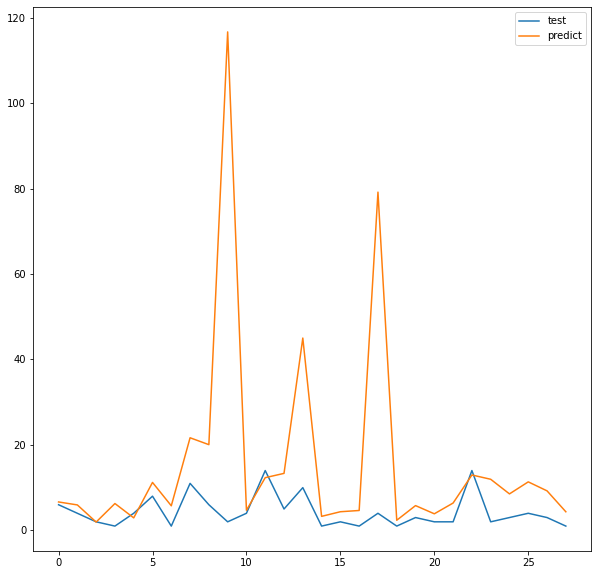

In [206]:
plt.figure(figsize=(10,10))
plt.plot(range(len(res.predict(sm.add_constant(X_test, has_constant='add')))),y_test,label='test')
plt.plot(range(len(res.predict(sm.add_constant(X_test, has_constant='add')))),res.predict(sm.add_constant(X_test, has_constant='add')),label='predict')
plt.legend()

In [207]:
br=GradientBoostingRegressor(**{'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 80})

br.fit(X_train,y_train)



GradientBoostingRegressor(max_depth=6, n_estimators=80)

In [208]:
mse(y_test,br.predict(X_test))

53.450164672947565

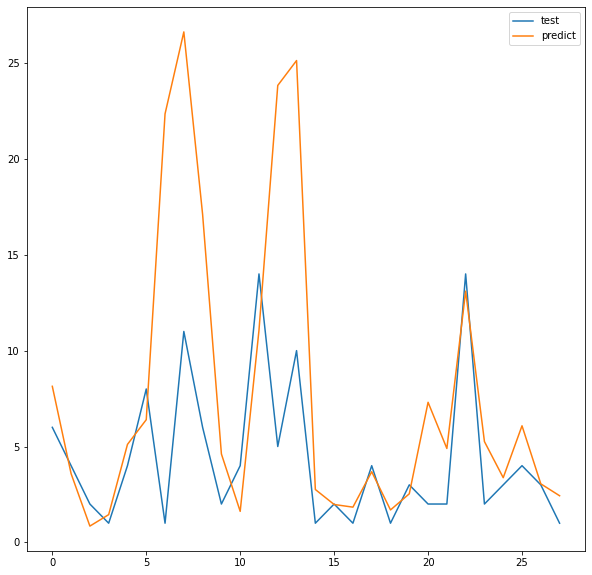

In [209]:
plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),br.predict(X_test),label='predict')
plt.legend()

In [210]:
br.predict(X_test).sum()

217.82504971412607

In [211]:
y_test.sum()

121

In [212]:
r2(br.predict(X_test),y_test)

0.108318043594536

In [213]:
grid_br_mape = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_absolute_percentage_error')
grid_br_mape.fit(X_train, y_train)


GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_absolute_percentage_error')

0.5311151463364614

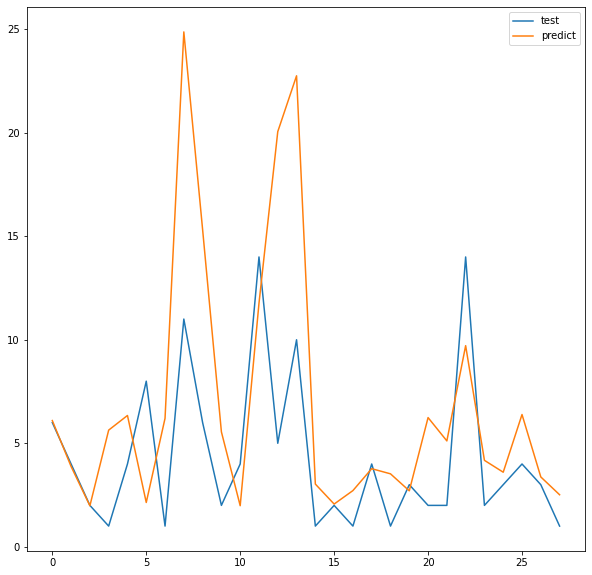

In [214]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mape.predict(X_test),label='predict')
plt.legend()

mape(grid_br_mape.predict(X_test),y_test)

In [215]:
grid_br_mse = GridSearchCV(GradientBoostingRegressor(), param_grid = param_dist,cv=3,n_jobs=4,scoring='neg_mean_squared_error')
grid_br_mse.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(), n_jobs=4,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.3, 0.4, 1],
                         'max_depth': [2, 4, 6, 8, 10],
                         'n_estimators': [30, 40, 100, 200, 300]},
             scoring='neg_mean_squared_error')

30.885693001356508

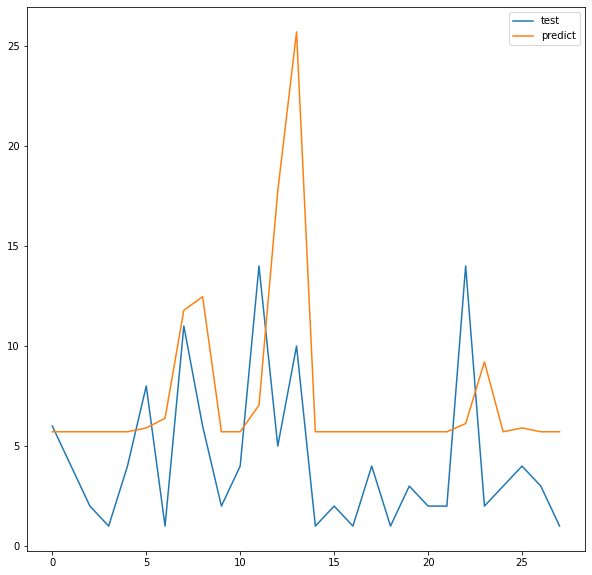

In [216]:

plt.figure(figsize=(10,10))
plt.plot(range(len(br.predict(X_test))),y_test,label='test')
plt.plot(range(len(br.predict(X_test))),grid_br_mse.predict(X_test),label='predict')
plt.legend()

mse(grid_br_mse.predict(X_test),y_test)